# EP2 - Modelando o SARS-CoV-2

$[x]$ Parte 1

$[x]$ Simulação Din - Parte 2

$[x]$ CSV

$[ ]$ Relatório

$[ ]$ Extra


Lara Ayumi Nagamatsu e Lucy Anne de Omena Evangelista

In [1]:
import math                          # exp(), ...
import matplotlib.pyplot as pyplot   # plot(), ...
import numpy as np                   # ones(), ...
import random                        # geração de números aleatórios
import pandas as pd

# Animação
from matplotlib import animation, rc
from IPython.display import HTML
import requests
import os
from io import BytesIO

Neste EP você vai simular o modelo dinâmico do COVID-19 resolvendo numericamente, por
Euler, a eq. para algumas situações diferentes ligadas aos parâmetros $\alpha, \lambda,$ A e $t_0$.

$$
\frac{dN}{dt} = \alpha \bigg(1 - \frac{N}{\eta t^2} \bigg)N - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N $$

sendo $\alpha > 0$ o fator de crescimento, $t_0$ o tempo inicial que depende de medidas de restrição, $\lambda = \sigma^{-1}$ e $\eta = 2A/t_0$, onde A é um parâmetro que depende do vírus e das medidas de restrição. O parâmetro $\eta$ foi usado em substitução do A.

# Método de Euler

Dado o enunciado, a função que nos interessa recebe como parâmetros {$\alpha, \lambda, t_0, A$} (neste caso, em vez de A recebo $\eta$). Sua evolução deve ser modelada a partir do método de Euler, por meio do qual se realiza uma aproximação da equação diferencial a partir de diferenças finitas:

$$
\frac{dN}{dt} =  \frac{N_{t+1} - N_{t}}{dt} \rightarrow N_{t+1} = N_t + \bigg[\alpha \bigg(1 - \frac{N}{\eta t^2} \bigg)N - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N \bigg]dt
$$

seja $N = N_t$, temos

$$
N_{t+1} = N_t + \bigg[\alpha \bigg(1 - \frac{N_t}{\eta t^2} \bigg)N_t - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N_t \bigg]dt \\
$$

que é o número de pessoas infectadas para um tempo $t$.

In [2]:
# N é o número de pessoas infectadas num certo tempo t

def nextN(N_0, dt, alfa, lamb, t0, eta, t):
    
    N  = alfa * (1-N_0 / (eta* t**2))
    aux = ( (2 * lamb * t**2 - 1) - (lamb * t0**2) * (math.exp(-lamb * (t - t0)**2)) )/ t
    N -= aux
    N *= N_0
    
    # Euler
    N *= dt
    N += N_0
    
    return N

# Parte 1 - Ilha Isolada
------------------------------------------------------

Assumindo que estamos numa ilha isolada, simule a evolução de N para um conjunto {$\alpha, \lambda$, A, $t_0$}. Nesse caso, o vetor de estados é unidimensional v(t) = \[N\](t). Faça um gráfico bonito para mostrar a evolução de v em relação a t, i.e. v(t). Faça também uma simulação dinâmica usando os recursos explicados em aula.

## Função para simulação 

In [3]:
# Retorna o vetor de estados

def sim():
    # Os dados abaixo foram retirados do 
    # documento do Sonnino para o caso da Itália (p. 12, figura 10)
    # https://arxiv.org/pdf/2003.13540v5.pdf
    
    N_0 = 1             # 165155 - número de casos inicial
    dt = 1              # passo = 1 dia
    t0 = 70.6           # parâmetro relativo ao pico da curva
    lamb = 0.0014       # para uma simulação decente, tem que usar na ordem de 10^{-3}
    alfa = 2*t0*lamb    # alfa = 2t0*lamb
    eta = 60.5
    
    t = 1
    N = N_0
    v = []
    
    while(N >= 1):
        v.append(int(N))
        t += dt
        N = nextN(N, dt, alfa, lamb, t0, eta, t)
        
    return v

## Gráfico para simulação

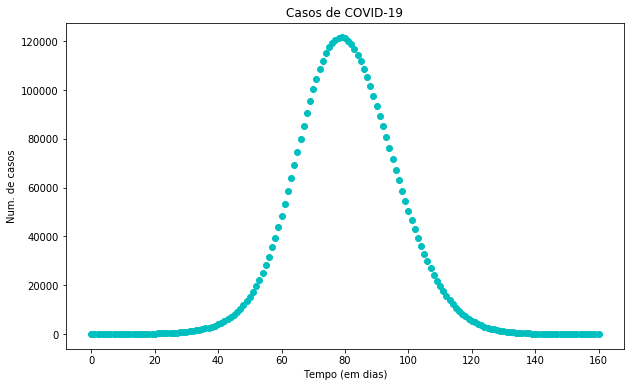

In [4]:
def simPlot(v):
    pyplot.figure(figsize=(10,6))
    pyplot.plot(v,linestyle='',marker='o',color='c')
    pyplot.title('Casos de COVID-19')
    pyplot.ylabel('Num. de casos')
    pyplot.xlabel('Tempo (em dias)')
    pyplot.show()    

values = sim()
simPlot(values)

## Animação da Simulação

In [5]:
def init_animate():
    line.set_data([], [])
    return (line,)

def animate(i):
    ind0 = i%len(yAnim)
    ind1 = ind0
    
    line.set_data([xAnim[:ind0], xAnim[:ind1]] , [yAnim[:ind0], yAnim[:ind1]])
    return (line,)

def createAnimPlot(title):
    figAnim = pyplot.figure(figsize=(10,6))
    axAnim = pyplot.axes(xlim=(-5, 165), ylim=(-100, 130000))
    # obs: o eixo muda se mudar os parâmetros de entrada
    
    pyplot.title(title)
    
    line, = axAnim.plot([], [], '*', lw=5, color='c')
    frames=len(yAnim)-1
    
    return(figAnim, axAnim, frames, line)

In [6]:
line = [None]
v = sim()
tempo = [i for i in range(len(v))]

yAnim = v
xAnim = tempo
figAnim, axAnim, frames, line = createAnimPlot('Casos de COVID-19 ao longo do tempo')
anim = animation.FuncAnimation(figAnim, animate, init_func=init_animate,
                               frames=frames, interval=50, blit=True)
rc('animation', html='jshtml')
pyplot.ylabel('Num. de casos')
pyplot.xlabel('Tempo (em dias)')
pyplot.close()

anim

## Dados em .csv

In [7]:
dados = [tempo, values]

pd.DataFrame(dados).T.to_csv("dados_IlhaIsolada.csv", header = ['tempo','casos'], index = False)

# Parte 2 - Cinco Ilhas
-----------------------------------------------------------
Agora, com sua experiência anterior, simule para cinco ilhas diferentes sorteando os valores de {$\alpha, \lambda$, A, $t_0$}. Nesse caso, o vetor de estados é 5-dimensional v(t) = \[$N_0, N_1, N_2, N_3, N_4$\](t). Faça gráficos bonitos para mostrar a evolução de v em relação a t, i.e. v(t) para as diferentes ilhas. Assim, os gráficos irão mostrar a evolução de $N_i$, onde onde i é um rótulo para cada ilha, em relação a t. Crie igualmente um gráfico mostrando a evolução do módulo de v(t), i.e. $||v(t)||$. Plote também os produtos cartesianos das coordenadas do vetor de estados, i.e. $N_0xN_1, N_0xN_2$, etc., de maneira similar aos gráficos de borboleta das equações de Lorenz. Faça também uma simulação dinâmica usando os recursos explicados em aula.

Visto que $\alpha$ é dependente de $\lambda$ e de $t_0$, os parâmetros sorteados aleatóriamente serão $\lambda, t_0, A$. 

## Função para simulação

In [8]:
# Retorna o vetor de estados de 4 dimensões

def sim_mult():
    random.seed(100)
    i = 0
    
    Ns = [[],[],[],[],[]]
    
    for i in range(0, 5): # vai de 0 a 4
        
        #lux = 0.0043, ita = 0.0014, bel = 0.0025
        random_num = random.uniform(0.001, 0.005) 
        lamb = random_num   # para uma simulação decente, tive que usar na ordem de 10^{-3}
        
        #lux = 38.5, ita = 70.6, bel = 48.8
        random_num = random.uniform(30, 90)
        t0 = random_num     # parâmetro relativo ao pico da curva?
        
        #A = (eta*t0)/2
        #lux = 82.775, ita = 2135.65, bel = 719.8
        random_num = random.uniform(600, 2500)
        A = random_num      # não muda mt coisa
        
        #lux = 4.3, ita = 60.5, bel = 29.5
        #eta = 2A/t0
        
        #lux = 0.33, alfa = 0.2, bel = 0.24
        alfa = 2*t0*lamb    # segundo o pdf

        init_N = 1          
        dt = 1
        t = 1
        N = init_N
        t_f = 140

        while(t <= t_f):
            Ns[i].append(int(N))
            t += dt
            N = nextN(N, dt, alfa, lamb, t0, A, t)
            
            if(N < 0):
                N = 0
                
    return Ns

## Dados em .csv

In [22]:
v = sim_mult()

pd.DataFrame(v).T.to_csv("dados_Ilhas.csv", 
                         header = ['Ilha1','Ilha2', 'Ilha3', 'Ilha4', 'Ilha5'], index = False)

## Gráficos da simução das ilhas em relação a t

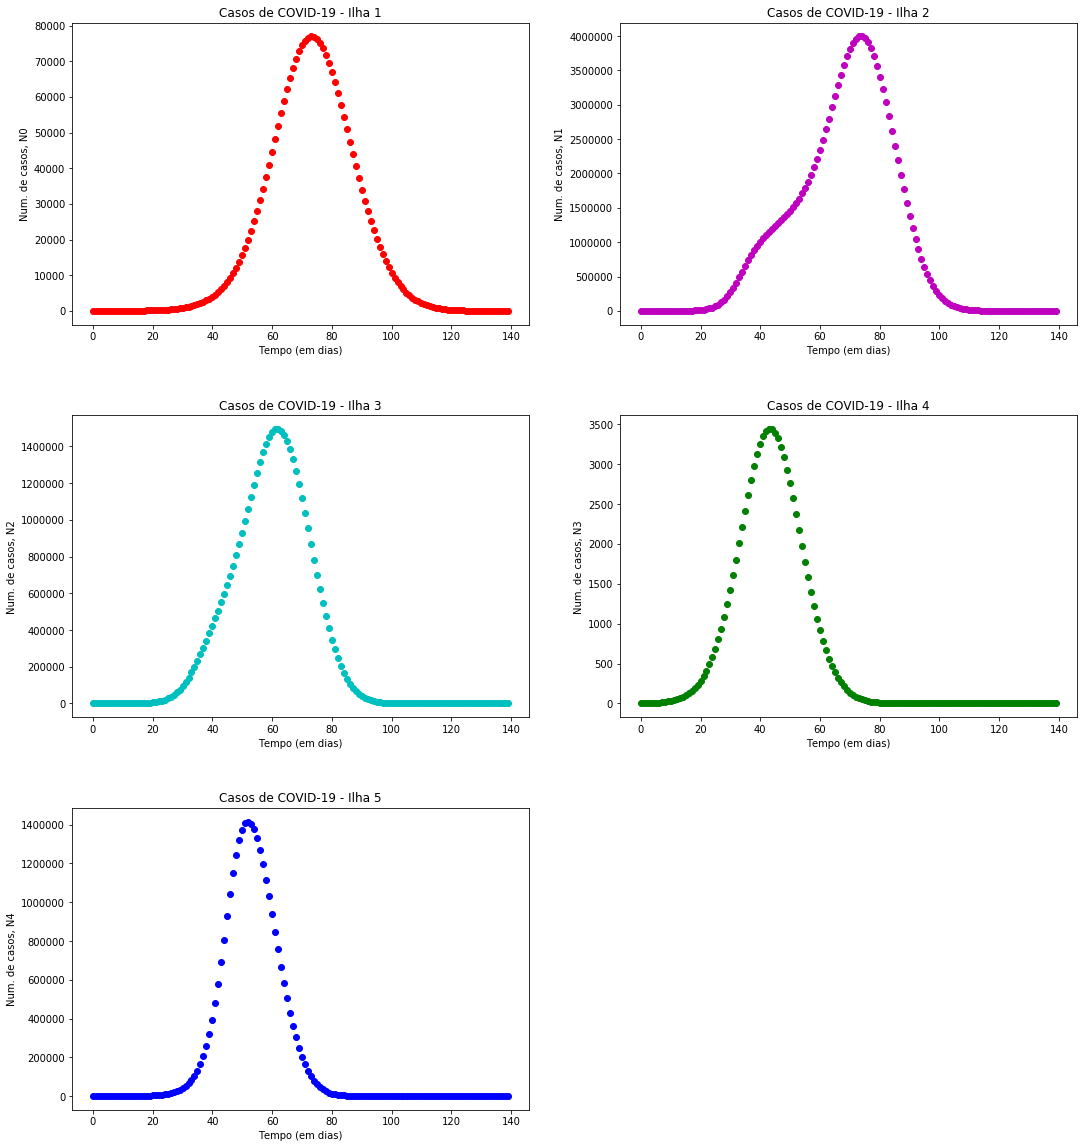

In [10]:
def simPlot_mult(v, colors):
    pyplot.figure(0, figsize=(18,20))
    pyplot.subplots_adjust(wspace=0.2, hspace=0.3)
    # mudar o tamanho dos blocos ^
    
    for i in range(len(v)):
        pyplot.subplot(3,2,i+1)
        pyplot.plot(v[i],linestyle='',marker='o', color = colors[i])
        pyplot.title('Casos de COVID-19 - Ilha '+ str(i+1))
        pyplot.ylabel("Num. de casos, N"+ str(i))
        pyplot.xlabel('Tempo (em dias)')

    pyplot.show()

colors = ['r', 'm', 'c', 'g','b']
simPlot_mult(sim_mult(), colors)

## Gráficos comparativos das ilhas:

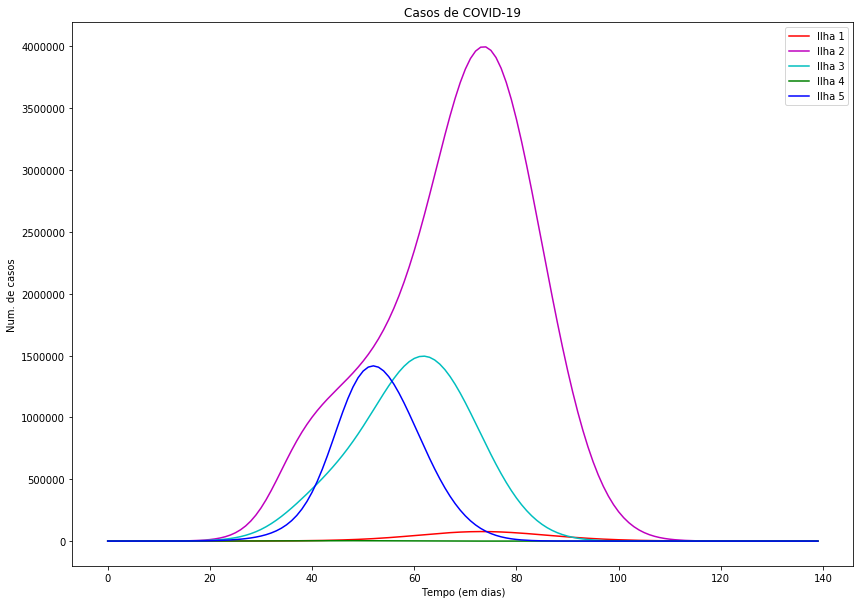

In [23]:
tempo = [i for i in range(len(v[0]))]

pyplot.figure(0, figsize=(14,10))
pyplot.title('Casos de COVID-19')
pyplot.ylabel('Num. de casos')
pyplot.xlabel('Tempo (em dias)')


for i in range(len(v)):
    pyplot.plot(tempo, v[i], colors[i], label="Ilha {}".format(i+1))
pyplot.legend()
pyplot.show()

### Simulação em gráfico em relação a $||v(t)||$:

É pedida a norma do vetor de estados, portanto, temos

$$||v(t)|| = \sqrt{(N_0(t))^2 + (N_1(t))^2 + (N_2(t))^2 + (N_3(t))^2 + (N_4(t))^2}$$

para cada t analisado.

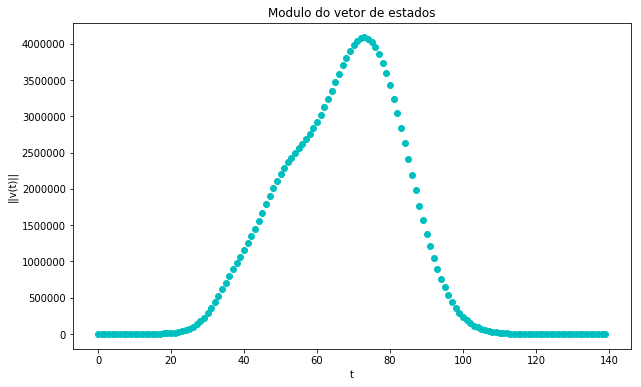

In [12]:
# Recebe um vetor de estados v, mostra o gráfico da norma

def simMod(v):
    N_size = len(v[0])
    i = total = 0
    mod = []
    
    for i in range (0, N_size):
        total = math.sqrt((v[0][i])**2 + (v[1][i])**2 + (v[2][i])**2 + (v[3][i])**2 + (v[4][i])**2)
        mod.append(total)
    
    pyplot.figure(figsize=(10,6))
    pyplot.plot(mod,linestyle='',marker='o',color='c')
    pyplot.title('Modulo do vetor de estados')
    pyplot.ylabel('||v(t)||')
    pyplot.xlabel('t')
    pyplot.show()

simMod(v)

### Simulação em produto cartesiano:

Abaixo, encontram-se os produtos cartesianos das coordenadas do vetor de estados. Assim, temos a representação de $N_ixN_j$, sendo $i \neq j$, assumindo valores $[0,1,2,3,4]$.

In [13]:
def sim_cart(v,case,ilha):
    i = 1;
    title = ''

    pyplot.figure(0, figsize=(13,10))
    pyplot.subplots_adjust(wspace=0.3, hspace=0.5)
    
    for j in range(len(v)):
        if(case != j):
            title = 'N'+str(case)+'xN'+str(j)
            
            pyplot.subplot(2,2,i)
            pyplot.plot(v[case], v[j], color='c')
            pyplot.title(title)
            pyplot.ylabel('$Ilha_{}$'.format(j))
            pyplot.xlabel(ilha)
            ax = pyplot.gca()
            pyplot.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
            i += 1

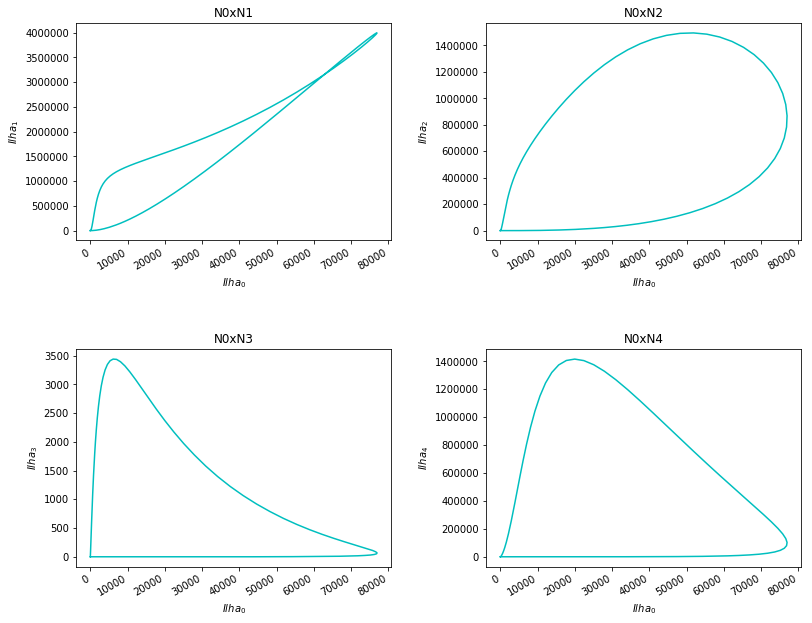

In [14]:
sim_cart(v, 0, '$Ilha_0$')

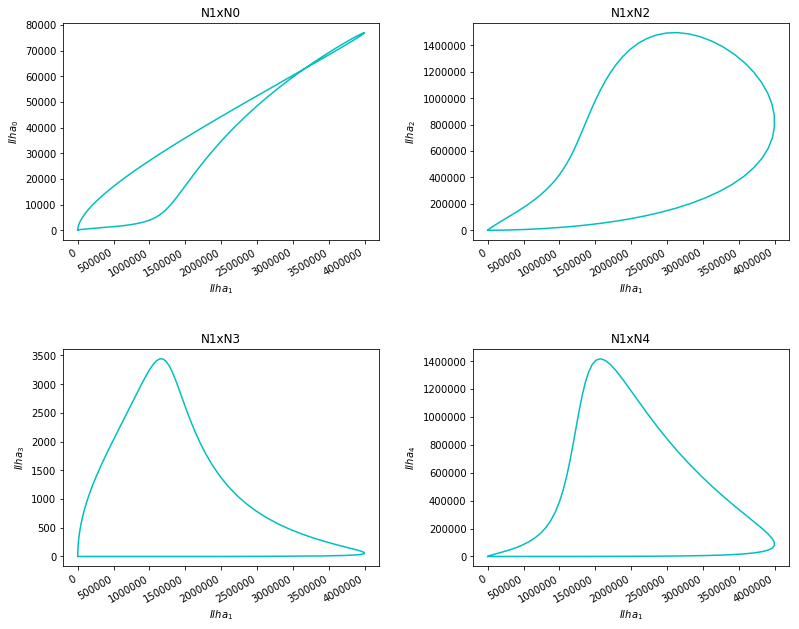

In [15]:
sim_cart(v, 1, '$Ilha_1$')

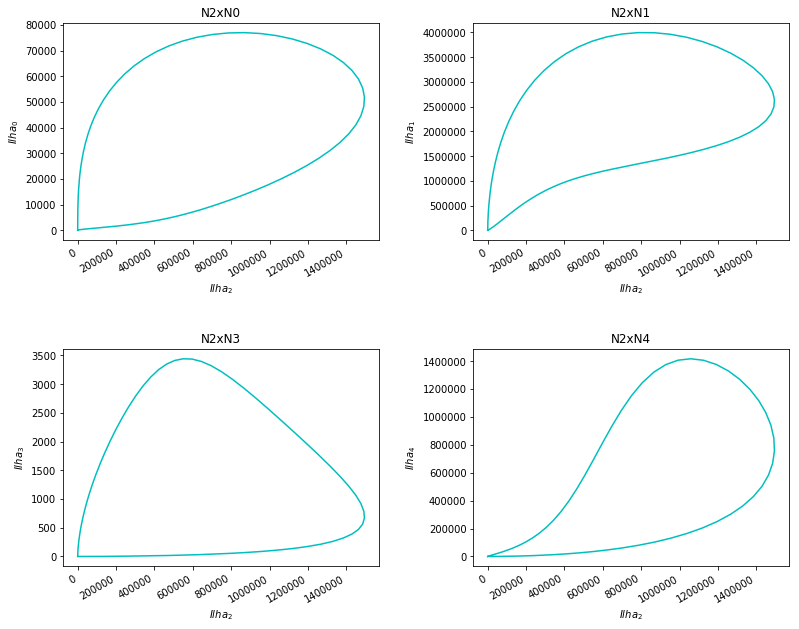

In [16]:
sim_cart(v, 2, '$Ilha_2$')

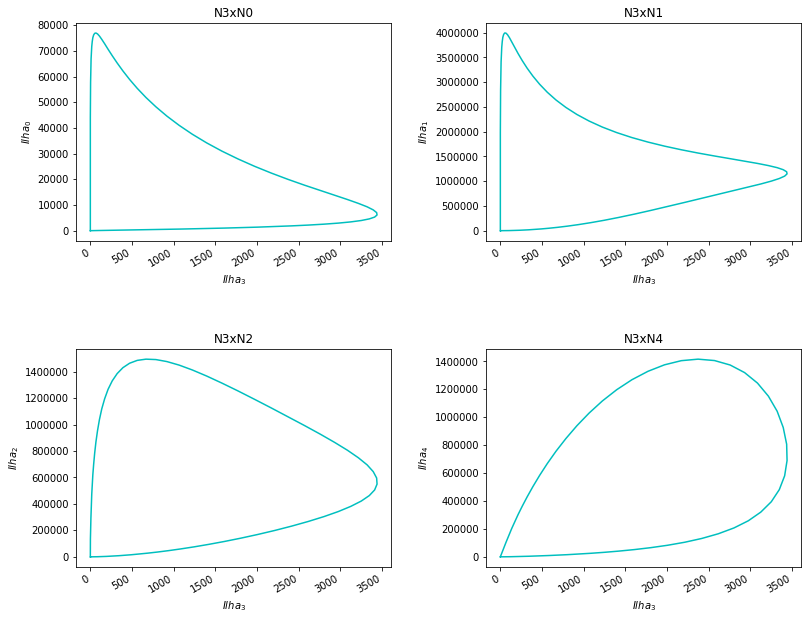

In [17]:
sim_cart(v, 3, '$Ilha_3$')

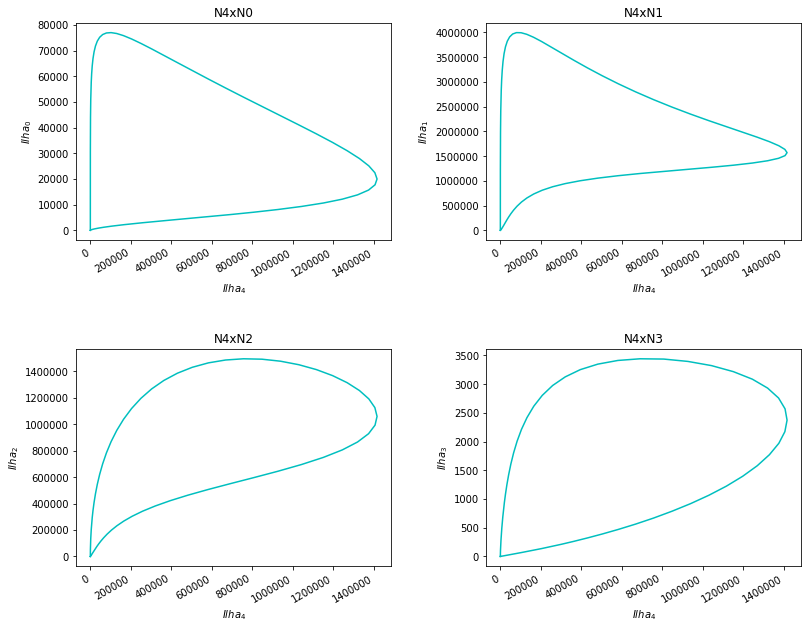

In [18]:
sim_cart(v, 4, '$Ilha_4$')

### Simulação Dinâmica:

Plotamos os gráficos das ilhas para ser possível observar a evolução dos casos.

In [19]:
def init_animate():
    for j in range(len(lines)):
        lines[j].set_data([], [])
    return (lines)

def animate(i):
    for j in range(len(lines)):
        ind0 = i%len(v[j])
        ind1 = ind0
        
        x = [xAnim[:ind0], xAnim[:ind1]]
        y = [v[j][:ind0], v[j][:ind1]]
        
        lines[j].set_data(x,y)
    
    return (lines)

def createAnimPlot(title):
    figAnim= pyplot.figure(figsize=(10,6))
    axAnim = pyplot.axes(xlim=(-5, 150), ylim=(-100, 4000000))
    # obs: o eixo muda se mudar os parâmetros de entrada
    
    pyplot.title(title)
    frames=len(xAnim)-1
    
    for j in range(len(lines)):
        lines[j], = pyplot.plot([], [], '*', lw=5, color=colors[j])
    
    return(figAnim, axAnim, frames, lines)

In [20]:
v = sim_mult()
tempo = [i for i range(len(v[0]))]
    
lines = [None] * 5

In [21]:
figAnim, tempo, frames, lines = createAnimPlot('Casos de COVID-19 ao longo do tempo')

anim = animation.FuncAnimation(figAnim, animate, init_func=init_animate, frames=frames,
                               interval=50, blit=False)
rc('animation', html='jshtml')
pyplot.ylabel('Num. de casos')
pyplot.xlabel('Tempo (em dias)')
pyplot.close()

anim